# Language Identification in South African Text: Kaggle Competition

This notebook presents my approach to tackle the Language Identification Challenge on Kaggle. The challenge focuses on classifying text written in South Africa's 11 Official languages. The notebook covers data exploration, preprocessing, feature extraction, model training, evaluation, and submission generation. By leveraging machine learning techniques, I aim to develop a classification model that accurately predicts the language of a given text.

## Importing necessary libraries

In [36]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import spacy
import string
import re
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from collections import Counter
from wordsegment import load, segment
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from nltk.corpus import stopwords
from wordcloud import WordCloud
from textblob import TextBlob
from collections import Counter
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.cluster import KMeans
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import Perceptron
from sklearn.ensemble import BaggingClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.ensemble import IsolationForest
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import StackingClassifier

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import GradientBoostingClassifier


## Loading the data

In [37]:
train_df = pd.read_csv('C:\\Users\\Neo\\Documents\\Language2\\train_set.csv')
test_df = pd.read_csv('C:\\Users\\Neo\\Documents\\Language2\\test_set.csv')

## Exploratory Data Analysis (EDA)

**Checking first could columns for train and test dataset**

In [38]:
print("Train Dataset:")
print(train_df.head())

print("\nTest Dataset:")
print(test_df.head())


Train Dataset:
  lang_id                                               text
0     xho  umgaqo-siseko wenza amalungiselelo kumaziko ax...
1     xho  i-dha iya kuba nobulumko bokubeka umsebenzi na...
2     eng  the province of kwazulu-natal department of tr...
3     nso  o netefatša gore o ba file dilo ka moka tše le...
4     ven  khomishini ya ndinganyiso ya mbeu yo ewa maana...

Test Dataset:
   index                                               text
0      1  Mmasepala, fa maemo a a kgethegileng a letlele...
1      2  Uzakwaziswa ngokufaneleko nakungafuneka eminye...
2      3         Tshivhumbeo tshi fana na ngano dza vhathu.
3      4  Kube inja nelikati betingevakala kutsi titsini...
4      5                      Winste op buitelandse valuta.


**Checking info**

In [46]:
# Display basic information about the datasets
print("Train Set:")
print(train_df.info())
print("\nTest Set:")
print(test_df.info())



Train Set:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33000 entries, 0 to 32999
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   lang_id  33000 non-null  object
 1   text     33000 non-null  object
dtypes: object(2)
memory usage: 515.8+ KB
None

Test Set:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5682 entries, 0 to 5681
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   index   5682 non-null   int64 
 1   text    5682 non-null   object
dtypes: int64(1), object(1)
memory usage: 88.9+ KB
None


**Two Visuals**

Train Set:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33000 entries, 0 to 32999
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   lang_id      33000 non-null  object
 1   text         33000 non-null  object
 2   text_length  33000 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 773.6+ KB
None

Summary Statistics:
        text_length
count  33000.000000
mean     244.907545
std       28.475588
min      201.000000
25%      220.000000
50%      243.000000
75%      269.000000
max      299.000000


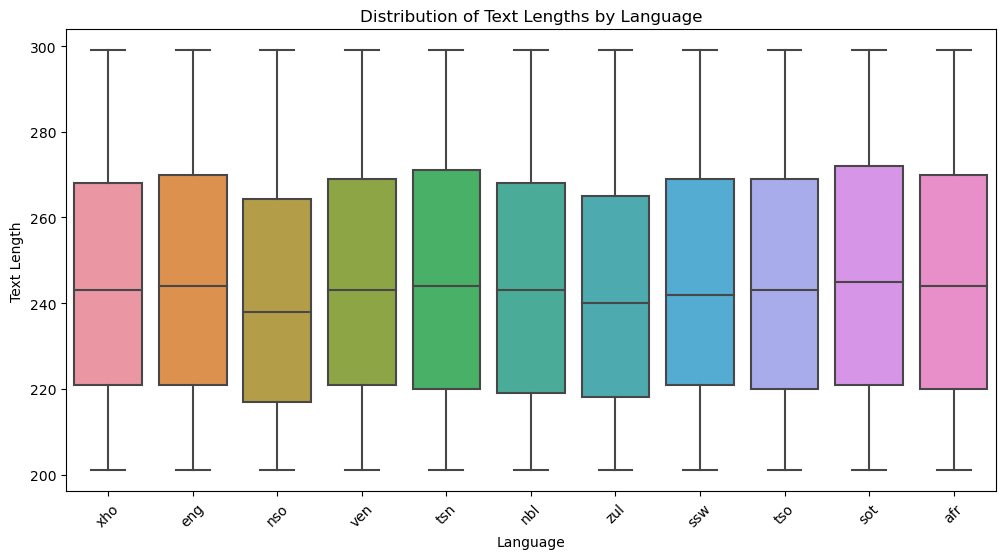

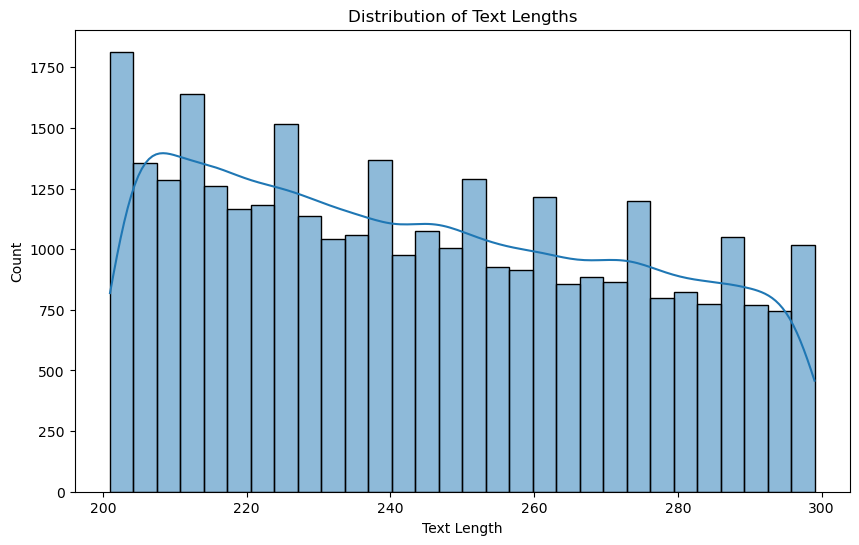

In [48]:
# Calculate text lengths
train_df['text_length'] = train_df['text'].apply(len)

# Display basic information about the dataset
print("Train Set:")
print(train_df.info())

# Summary statistics (excluding non-numeric columns)
numeric_columns = train_df.select_dtypes(include=['int64', 'float64']).columns
print("\nSummary Statistics:")
print(train_df[numeric_columns].describe())

# Distribution of text lengths by language
plt.figure(figsize=(12, 6))
sns.boxplot(x='lang_id', y='text_length', data=train_df)
plt.title('Distribution of Text Lengths by Language')
plt.xlabel('Language')
plt.ylabel('Text Length')
plt.xticks(rotation=45)
plt.show()

# Text length distribution
plt.figure(figsize=(10, 6))
sns.histplot(train_df['text_length'], bins=30, kde=True)
plt.title('Distribution of Text Lengths')
plt.xlabel('Text Length')
plt.ylabel('Count')
plt.show()




**Observation**

*Distribution of text lengths by language*

•This visual is a box plot graph showing the distribution of text lengths by language.

•The visual shows that all languages have the same (similar) IQR, which means they have the same variability in text length.
These languages have the most variability in text length, as they have the widest range of values.


*Distribution of text lengths*

• This visual shows the distribution of text lengths in a dataset. It tells us that most texts are around 200 characters long, and that longer texts are less frequent. 





**Word cloud for each language**


Word Cloud for xho:


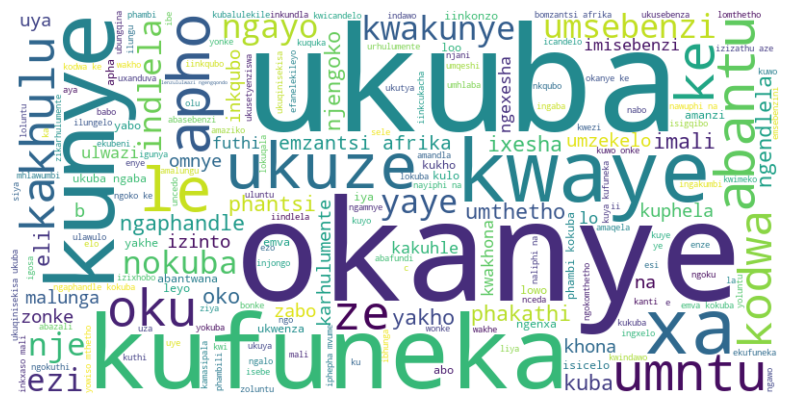


Word Cloud for eng:


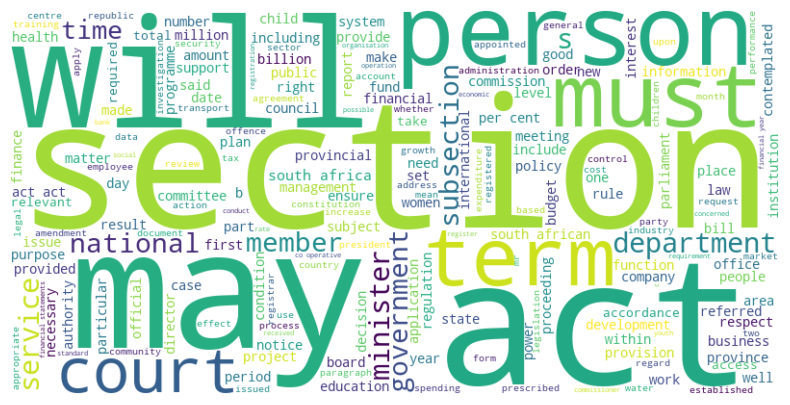


Word Cloud for nso:


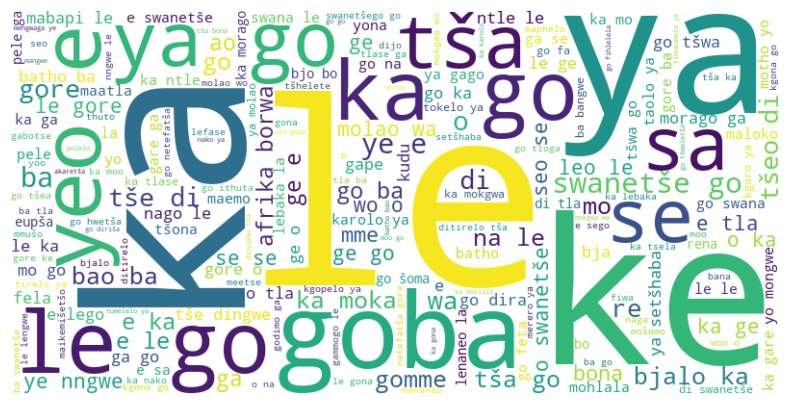


Word Cloud for ven:


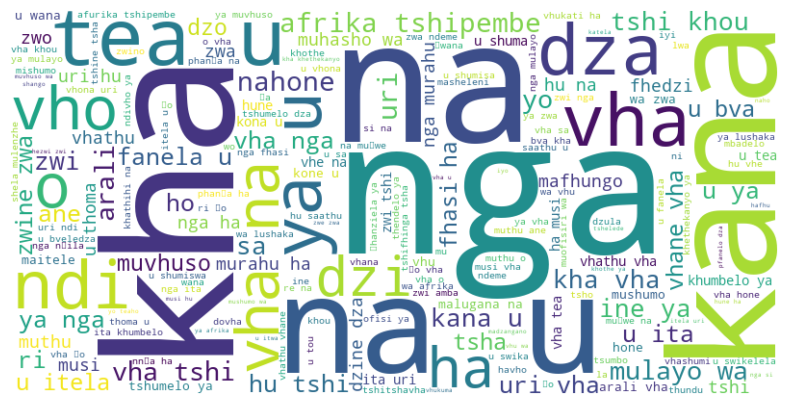


Word Cloud for tsn:


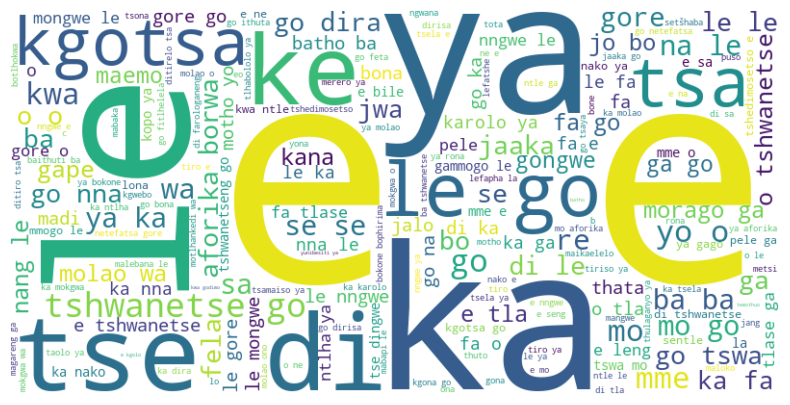


Word Cloud for nbl:


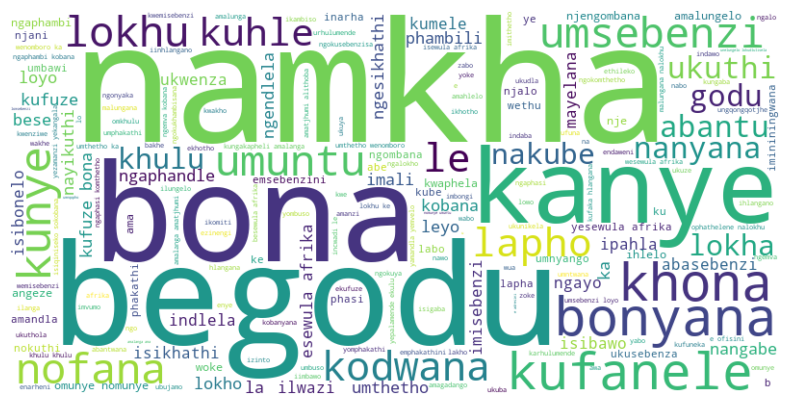


Word Cloud for zul:


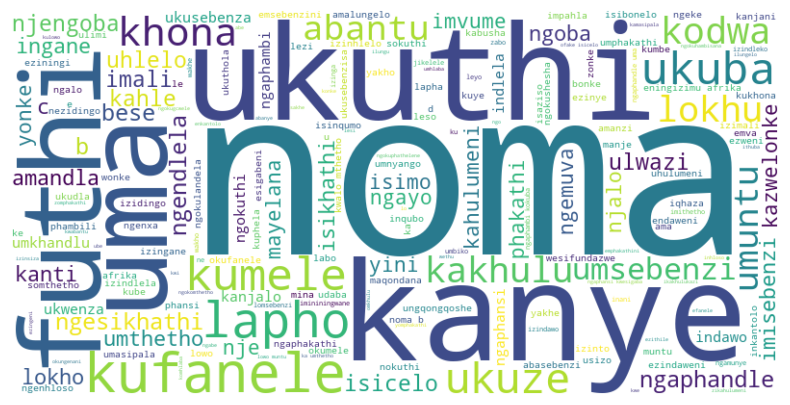


Word Cloud for ssw:


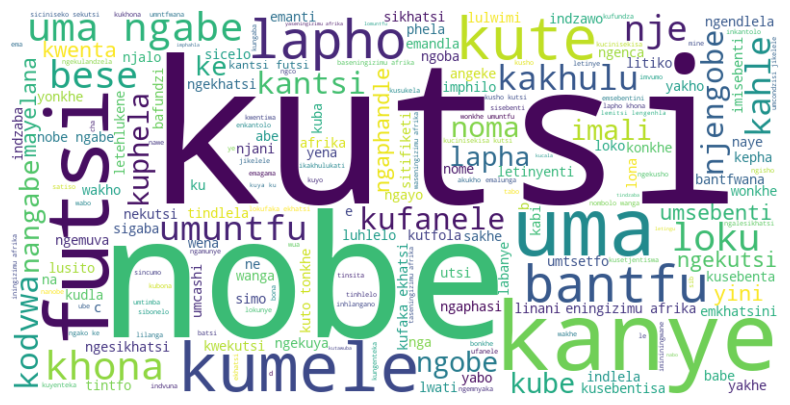


Word Cloud for tso:


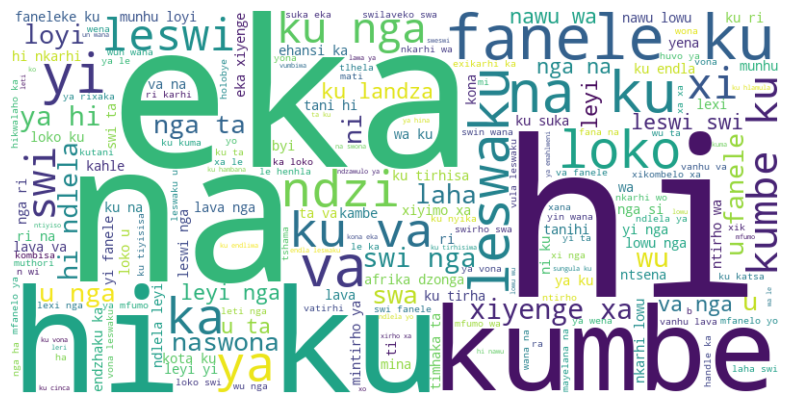


Word Cloud for sot:


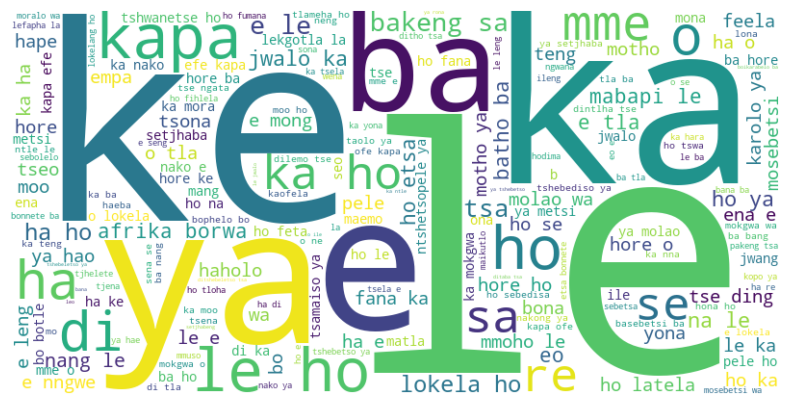


Word Cloud for afr:


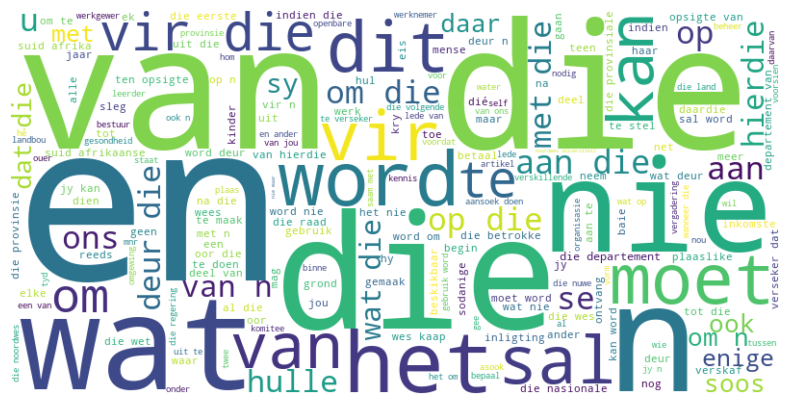

In [54]:


# Function to generate word cloud
def generate_word_cloud(text):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

# Generate word clouds for each language
for lang in train_df['lang_id'].unique():
    lang_text = ' '.join(train_df[train_df['lang_id'] == lang]['text'])
    print(f"\nWord Cloud for {lang}:")
    generate_word_cloud(lang_text)




**Observation**

From the word clouds we observe that the size of each word indicates its frequency or importance within the text. The more frequently a word appears in the text, the larger and bolder it appears in the word cloud.

**Distribution of counts**

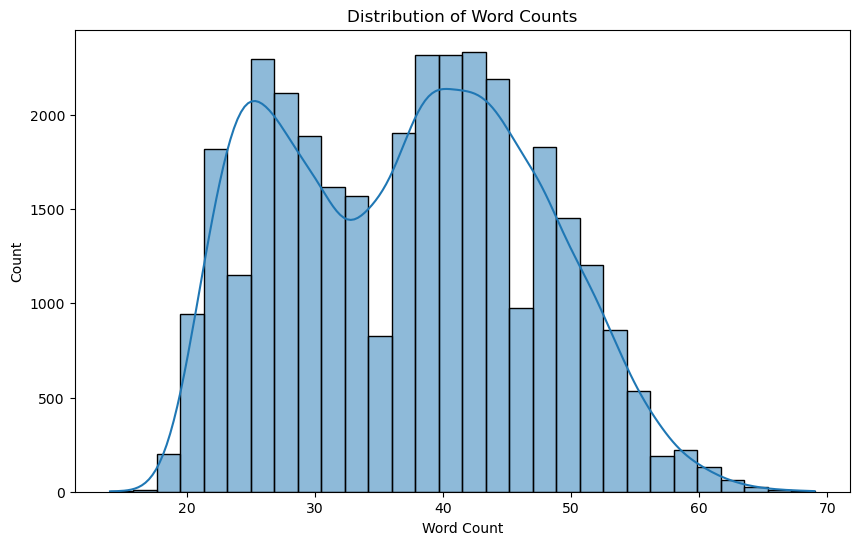

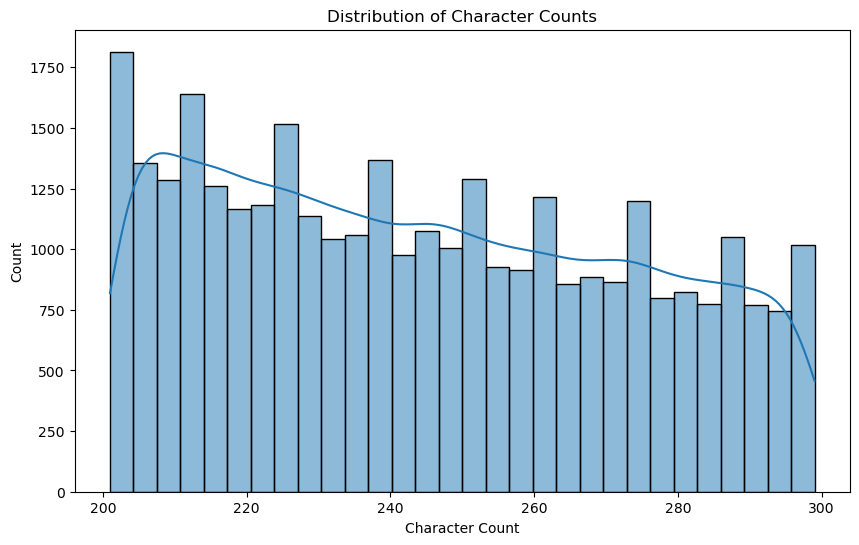

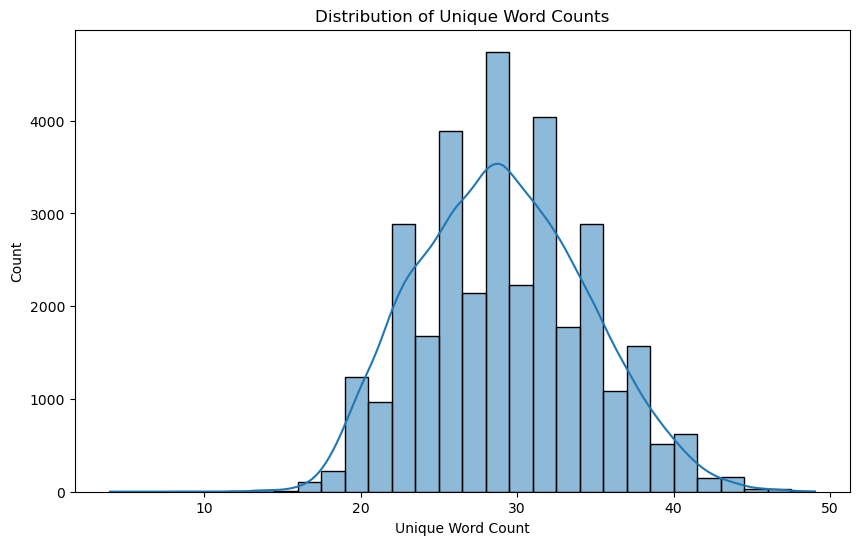

In [55]:
# Distribution of word counts
plt.figure(figsize=(10, 6))
sns.histplot(train_df['text'].apply(lambda x: len(x.split())), bins=30, kde=True)
plt.title('Distribution of Word Counts')
plt.xlabel('Word Count')
plt.ylabel('Count')
plt.show()

# Character count distribution
plt.figure(figsize=(10, 6))
sns.histplot(train_df['text'].apply(len), bins=30, kde=True)
plt.title('Distribution of Character Counts')
plt.xlabel('Character Count')
plt.ylabel('Count')
plt.show()

# Unique word count distribution
plt.figure(figsize=(10, 6))
sns.histplot(train_df['text'].apply(lambda x: len(set(x.split()))), bins=30, kde=True)
plt.title('Distribution of Unique Word Counts')
plt.xlabel('Unique Word Count')
plt.ylabel('Count')
plt.show()


**Observation**

*Distribution of word counts*



• There are peaks around 20-30 and 50-60 word counts, indicating that texts with these lengths are more common in the dataset.

• The dataset contains texts with varying lengths, but most of them are between 10 and 60 words long.






*Distribution of character count distribution*

• The graph tells us that most of the data has around 200 characters, and that the frequency of character counts decreases as they get longer.

*Distribution of unique word counts*

• The most common unique word count is around 30, as indicated by the peak in both plots. This means that most of the text data has about 30 words that are not repeated anywhere else in the data.

• The distribution is skewed to the right, meaning that there are more low values than high values. This suggests that the text data is diverse and has a lot of variation in word usage.

• The distribution has a long tail, meaning that there are some very high values that are rare. This indicates that there are some outliers or anomalies in the text data that have a lot of unique words.




**Most frequent words**

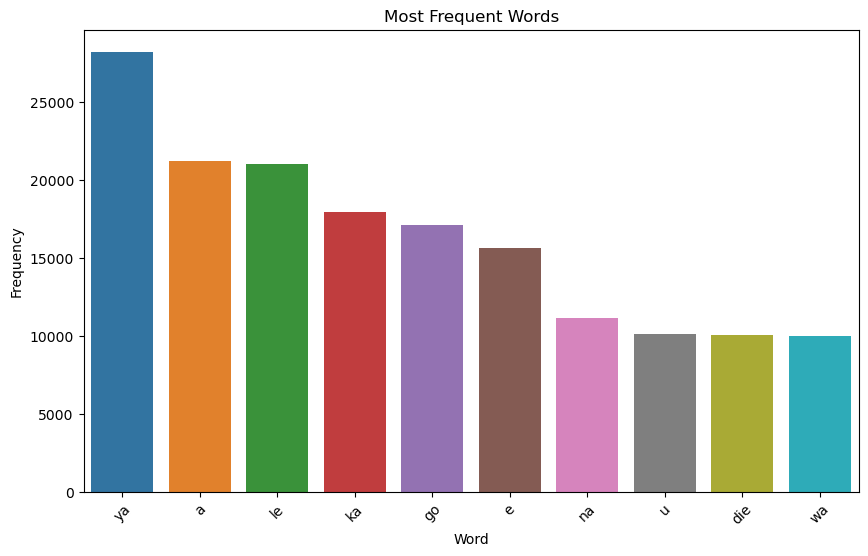

In [59]:


# Most frequent words
def plot_most_frequent_words(text, num_words=10):
    word_list = ' '.join(text).split()
    word_counts = Counter(word_list)
    most_common = word_counts.most_common(num_words)
    words, counts = zip(*most_common)
    plt.figure(figsize=(10, 6))
    sns.barplot(x=list(words), y=list(counts))
    plt.title('Most Frequent Words')
    plt.xlabel('Word')
    plt.ylabel('Frequency')
    plt.xticks(rotation=45)
    plt.show()

plot_most_frequent_words(train_df['text'])




**Observation**

• The word “the” is the most frequent, followed by “a”, “and”, and so on.

• The word “the” is more than twice as frequent as the word “a”, which suggests that the dataset contains more definite than indefinite nouns.

• The word “was” is the least frequent among the top ten words, which implies that the dataset has more present tense than past tense verbs.

• The word “it” is more frequent than the word “that”, which indicates that the dataset has more pronouns than demonstratives.

## Data Preprocessing

In [77]:

# Initialize n-gram vectorizer
ngram_vectorizer = CountVectorizer(ngram_range=(1, 2))

# Fit and transform n-gram vectorizer on training data
X_train_ngrams = ngram_vectorizer.fit_transform(train_df['clean_text'])

# Transform test data using the same vectorizer
X_test_ngrams = ngram_vectorizer.transform(test_df['clean_text'])


In [78]:
def preprocess_data(train_df, test_df):
    # Initializing the TF-IDF vectorizer
    vectorizer = TfidfVectorizer()

    # Fitting the vectorizer on the training data
    vectorizer.fit(train_df['text'])

    # Transforming the training and test data using the fitted vectorizer
    train_features = vectorizer.transform(train_df['text'])
    test_features = vectorizer.transform(test_df['text'])

    return train_features, test_features, vectorizer



## Preprocessing the data

In [79]:
train_features, test_features, vectorizer = preprocess_data(train_df, test_df)


## Training and Evaluation

### Logistic Regression

In [57]:
X_train, X_val, y_train, y_val = train_test_split(train_features, train_df['lang_id'], test_size=0.2, random_state=42)
lr_model = LogisticRegression()
lr_model.fit(X_train, y_train)
lr_preds = lr_model.predict(X_val)
lr_f1 = f1_score(y_val, lr_preds, average='weighted')

print("Logistic Regression F1 Score:", lr_f1)


Logistic Regression F1 Score: 0.994245605433102


C:\Users\Neo\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### K Nearest Neighbors (KNN)

In [56]:
knn_model = KNeighborsClassifier()
knn_model.fit(X_train, y_train)
knn_preds = knn_model.predict(X_val)
knn_f1 = f1_score(y_val, knn_preds, average='weighted')

print("KNN F1 Score:", knn_f1)


KNN F1 Score: 0.9593450685034197


### Support Vector Machine

In [58]:
svm = SVC()
svm.fit(X_train, y_train)
svm_predictions = svm.predict(X_val)
svm_f1 = f1_score(y_val, svm_predictions, average='weighted')
print("SVM F1 Score:", svm_f1)

SVM F1 Score: 0.9942650475719715


### Naive Bayes

In [70]:
nb = MultinomialNB()
nb.fit(X_train, y_train)
nb_predictions = nb.predict(X_val)
nb_f1 = f1_score(y_val, nb_predictions, average='weighted')
print("Naive Bayes F1 Score:", nb_f1)


Naive Bayes F1 Score: 0.9980299054262277


In [80]:

# Define the Naive Bayes model
nb = MultinomialNB()

# Hyperparameter tuning
parameters = {'alpha': [0.1, 0.5, 1.0, 2.0, 5.0]}  # Example alpha values for smoothing
nb_grid = GridSearchCV(nb, parameters, cv=5, scoring='f1_weighted')
nb_grid.fit(X_train, y_train)

# Get the best model from grid search
best_nb = nb_grid.best_estimator_

# Make predictions on the validation set
nb_predictions = best_nb.predict(X_val)

# Calculate F1 score
nb_f1 = f1_score(y_val, nb_predictions, average='weighted')

# Print the F1 score
print("Naive Bayes F1 Score:", nb_f1)


Naive Bayes F1 Score: 0.9990909140677504


## Generate predictions on the test set

In [74]:
# Converting the test data into TF-IDF vectors
X_test = vectorizer.transform(test_df['text'])

# Generating predictions on the best performing model
test_predictions = best_nb.predict(X_test)

## Creating a csv for submission

In [75]:
# Creating a submission dataframe with 'index' and 'lang_id' columns
submission_df = pd.DataFrame({'index': test_df['index'], 'lang_id': test_predictions})

submission_df.to_csv('FinalSub1.csv', index=False)

## Model Evaluation

From the data I observed that the best model to give the best F1 score is Naive Bayes